In [66]:
import numpy as np
import pandas as pd
import random
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import os
import shutil
from sklearn.model_selection import train_test_split

## **Creating dataset from owned data** ##

In [2]:
def create_directory(my_path, dir_name):
    directory_name = dir_name
    if os.path.exists(os.path.join(my_path, directory_name)):
        shutil.rmtree(os.path.join(my_path, directory_name))
    os.mkdir(my_path + '/' + directory_name)

In [3]:
def choose_pictures(n, path_name, dest_name):
    source_folder = os.path.join(path_name, "Humans")
    destination_folder = os.path.join(path_name, dest_name)

    os.makedirs(destination_folder, exist_ok=True)

    all_files = [file for file in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, file))]

    if len(all_files) < n:
        print(f"Not enough pictures in the source folder. Found only {len(all_files)} files.")
    else:
        selected_files = random.sample(all_files, n)
        for file in selected_files:
            shutil.copy(os.path.join(source_folder, file), os.path.join(destination_folder, file))


In [4]:
def resize_all_pictures(path_name, dir_name, width, height):
    source_folder = os.path.join(path_name, dir_name)
    for file in os.listdir(source_folder):
        if file == '.DS_Store':
            continue
        img = Image.open(os.path.join(source_folder, file))
        img = img.resize((width, height))
        img.save(os.path.join(source_folder, file))

In [5]:
def draw_black_rectangle(path_name, dir_name, r_width, r_height):
    source_folder = os.path.join(path_name, dir_name)
    for file in os.listdir(source_folder):
        if file == '.DS_Store':
            continue

        img = cv2.imread(os.path.join(source_folder, file))
        height, width, _ = img.shape

        rect_width, rect_height = r_width, r_height
        if rect_width > width or rect_height > height:
            print("Rectangle size exceeds image dimensions!")
            return

        x = random.randint(80, 120)
        y = random.randint(80, 120)

        color = (0, 0, 0)
        thickness = -1
        cv2.rectangle(img, (x, y), (x + rect_width, y + rect_height), color, thickness)
        cv2.imwrite(os.path.join(source_folder, file), img)

In [6]:
def copy_directory_contents(path_name, dir1, dir2):
    source_dir = os.path.join(path_name, dir1)
    dest_dir = os.path.join(path_name, dir2)
    for file_name in os.listdir(source_dir):
        source_file = os.path.join(source_dir, file_name)
        destination_file = os.path.join(dest_dir, file_name)

        if os.path.isfile(source_file):
            shutil.copy2(source_file, destination_file)

In [7]:
def create_datasets(path_name):
    # 1a. Create input data directory
    create_directory(path_name, "input_data")
    # 1b. Create output data directory
    create_directory(path_name, "output_data")
    # 2. Choose 1000 random images
    choose_pictures(1000, path_name, "output_data")
    # 3. Resize output data
    resize_all_pictures(path_name, "output_data", 224, 224)
    # 4. Copy output folder as input data
    copy_directory_contents(path_name, "output_data", "input_data")
    # 5. Draw black rectangle on output data
    draw_black_rectangle(path_name, "input_data", 60, 60)

In [ ]:
# create_datasets("C:/Users/user/Desktop/AI/V sem/CV/CV_project3")

## Data augmentation

In [8]:
import os
import cv2
import random
from albumentations import (
    VerticalFlip, Rotate, RandomBrightnessContrast, ShiftScaleRotate, Compose, OneOf
)
# from albumentations.core.composition import BboxParams

def create_output_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

def augment_pair(image_x, image_y):
    """Define the augmentation pipeline and apply it to both X and Y images."""
    transform = Compose([
        VerticalFlip(p=0.5),
        OneOf([
            Rotate(limit=15, p=0.5),
            ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        ], p=1.0),
        RandomBrightnessContrast(p=0.5),
    ])
    augmented = transform(image=image_x, mask=image_y)
    return augmented['image'], augmented['mask']

def preprocess_paired_images(input_x_folder, input_y_folder, output_x_folder, output_y_folder, augmentation_ratio=0.5):
    """Preprocess paired input and target images."""
    # Create output folders if they don't exist
    create_output_folder(output_x_folder)
    create_output_folder(output_y_folder)

    # Get list of images
    images_x = [f for f in os.listdir(input_x_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    images_y = [f for f in os.listdir(input_y_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Ensure paired images match
    if len(images_x) != len(images_y):
        raise ValueError("Number of images in input_x and input_y folders must match.")
    
    # Sort to ensure pairs are aligned
    images_x.sort()
    images_y.sort()
    total_images = len(images_x)

    # Determine the number of images to augment
    num_to_augment = int(total_images * augmentation_ratio)
    images_to_augment = random.sample(range(total_images), num_to_augment)

    for idx, (image_x_name, image_y_name) in enumerate(zip(images_x, images_y)):
        # Load the paired images
        input_x_path = os.path.join(input_x_folder, image_x_name)
        input_y_path = os.path.join(input_y_folder, image_y_name)
        image_x = cv2.imread(input_x_path)
        image_y = cv2.imread(input_y_path)

        # image_x = cv2.cvtColor(image_x, cv2.COLOR_BGR2RGB)  # Convert X to RGB if needed

        # Apply augmentation if this image is selected
        if idx in images_to_augment:
            augmented_x, augmented_y = augment_pair(image_x, image_y)
        else:
            augmented_x, augmented_y = image_x, image_y

        # Save the augmented images
        output_x_path = os.path.join(output_x_folder, f"processed_x_{idx+1:04d}.jpg")
        output_y_path = os.path.join(output_y_folder, f"processed_y_{idx+1:04d}.png")
        
        # augmented_x = cv2.cvtColor(augmented_x, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
        cv2.imwrite(output_x_path, augmented_x)
        cv2.imwrite(output_y_path, augmented_y)

    print(f"All image pairs processed and saved in '{output_x_folder}' and '{output_y_folder}'.")

In [9]:
# input_x_folder = 'input_data'
# input_y_folder = 'output_data'
# output_x_folder = 'input_data_augm'
# output_y_folder = 'output_data_augm'

# preprocess_paired_images(input_x_folder, input_y_folder, output_x_folder, output_y_folder, augmentation_ratio=0.4)

## **Neural Network model** ##

In [10]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, Conv2DTranspose, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as keras

In [11]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [56]:
def get_downsample(in_layer, filters):
    conv1 = Conv2D(filters, (3,3), padding='same',activation="relu")(in_layer)
    conv2 = Conv2D(filters, (3,3), padding='same',activation="relu")(conv1)

    out_for_skip = conv2

    pool = MaxPooling2D(pool_size=(2, 2))(conv2)

    return pool, out_for_skip

def get_upsample(in_layer, filters, skip):
    upsample = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(in_layer)
    upconv = concatenate([upsample, skip], axis=3)
    conv1 = Conv2D(filters, (3,3), padding='same',activation="relu")(upconv)
    conv2 = Conv2D(filters, (3,3), padding='same',activation="relu")(conv1)
    return conv2

def get_bottleneck(in_layer, filters):
    conv1 = Conv2D(filters, (3,3), padding='same',activation="relu")(in_layer)
    conv2 = Conv2D(filters, (3,3), padding='same',activation="relu")(conv1)
    return conv2

def get_unet(depth=3):
    layers = [Input(shape=(None,None,3))]
    skips = []
    
    for i in range(depth):
        down,skip = get_downsample(layers[-1],2**(i+5))
        layers.append(down)
        skips.append(skip)

    layers.append(get_bottleneck(layers[-1],2**(depth+5)))

    for i in reversed(range(depth)):
        up = get_upsample(layers[-1],2**(i+5),skips[i])
        layers.append(up)

    layers.append(Conv2D(3, (1,1), padding='same',activation="sigmoid")(layers[-1]))

    model = Model(inputs=layers[0], outputs=layers[-1])
    model.compile(optimizer='adam', loss='mse')
    
    return model

In [57]:
model = get_unet()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, None,      │        896 │ input_layer_1[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, None,      │      9,248 │ conv2d_15[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, None,      │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, None,      │     18,496 │ max_pooling2d_3[… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, None,      │     36,928 │ conv2d_17[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, None,      │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, None,      │     73,856 │ max_pooling2d_4[… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, None,      │    147,584 │ conv2d_19[0][0]   │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, None,      │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, None,      │    295,168 │ max_pooling2d_5[… │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, None,      │    590,080 │ conv2d_21[0][0]   │
│                     │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, None,      │    131,200 │ conv2d_22[0][0]   │
│ (Conv2DTranspose)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, None,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ None, 256)        │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, None,      │    295,040 │ concatenate_3[0]… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, None,      │    147,584 │ conv2d_23[0][0]   │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, None,      │     32,832 │ conv2d_24[0][0] 

 Total params: 1,925,667 (7.35 MB)

 Trainable params: 1,925,667 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
def read_pictures(path_name, dir):
    l = []
    source_dir = os.path.join(path_name, dir)
    for file in os.listdir(source_dir):
        if file == '.DS_Store':
            continue
        img = cv2.imread(os.path.join(source_dir, file))
        l.append((img, file))
    l.sort(key = lambda x: x[1])
    l = [i[0] for i in l]
    return l

In [59]:
x = read_pictures('/Users/Kuba/Desktop/CV_project3','input_data_augm')
y = read_pictures('/Users/Kuba/Desktop/CV_project3', 'output_data_augm')

In [60]:
train_x, temp_x_split, train_y, temp_y_split = train_test_split(x, y, test_size=0.3, random_state=42)  # 30% reserved for validation and testing
val_x, test_x, val_y, test_y = train_test_split(temp_x_split, temp_y_split, test_size=1/3, random_state=42)

In [61]:
train_x = np.array(train_x)/255.0
train_y = np.array(train_y)/255.0
val_x = np.array(val_x)/255.0
val_y = np.array(val_y)/255.0
test_x = np.array(test_x)/255.0
test_y = np.array(test_y)/255.0

In [63]:
model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs = 50)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 569ms/step - loss: 0.0185 - val_loss: 0.0162
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 546ms/step - loss: 0.0142 - val_loss: 0.0097
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 546ms/step - loss: 0.0108 - val_loss: 0.0081
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 547ms/step - loss: 0.0092 - val_loss: 0.0078
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 545ms/step - loss: 0.0084 - val_loss: 0.0070
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 552ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 553ms/step - loss: 0.0077 - val_loss: 0.0086
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 553ms/step - loss: 0.0080 - val_loss: 0.0062
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 557ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 559ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 585ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 12

In [64]:
pred = model.predict(test_x)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


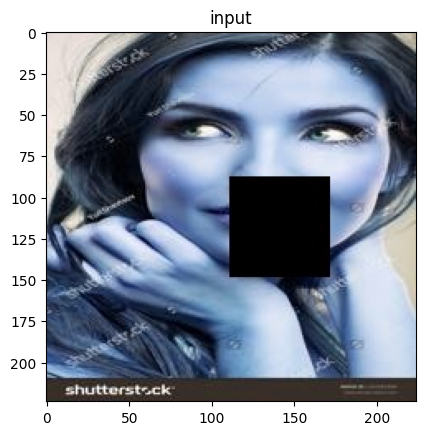

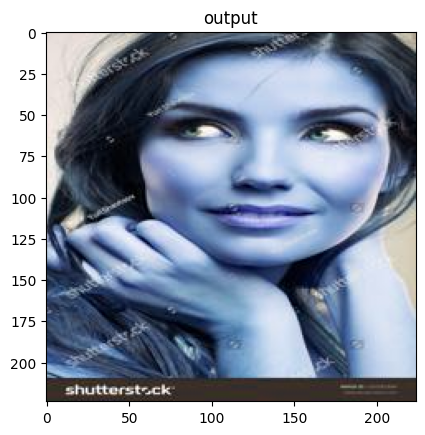

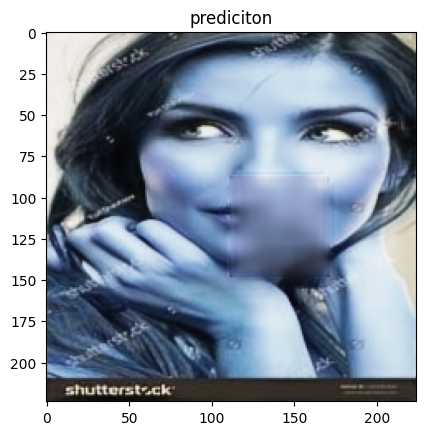

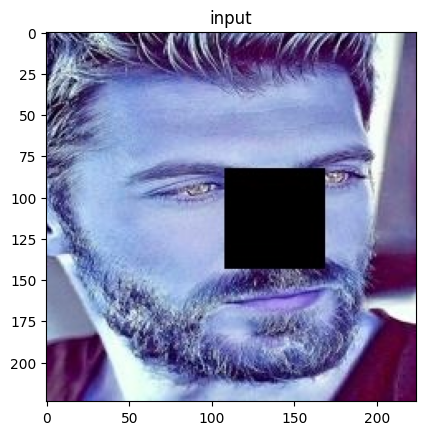

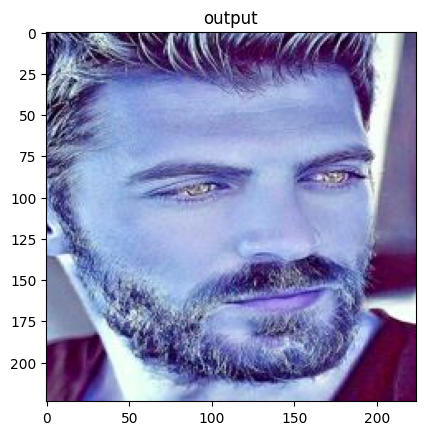

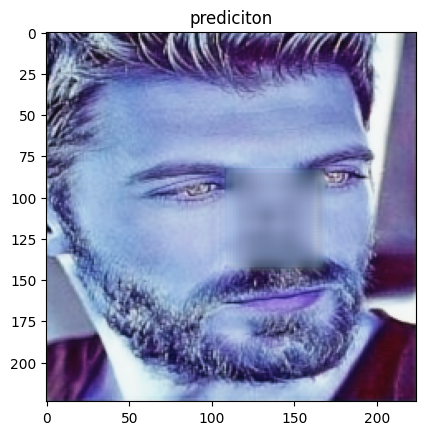

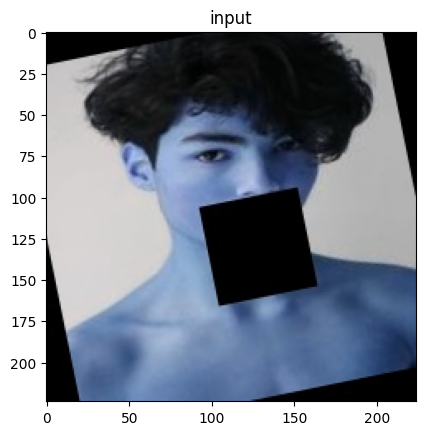

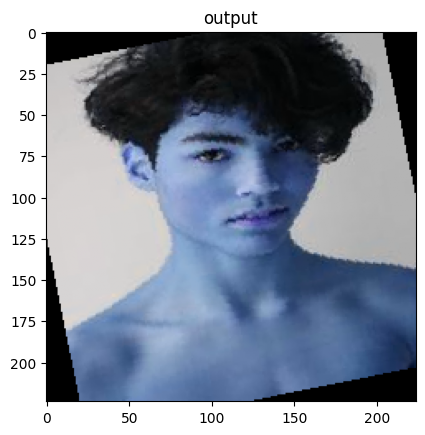

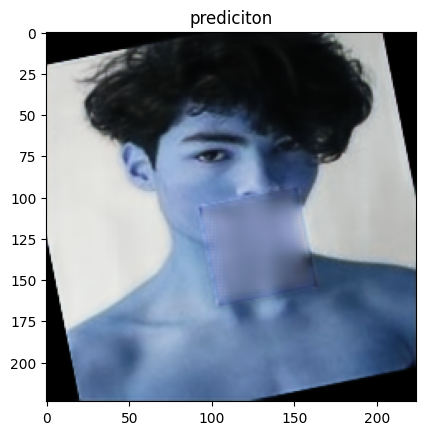

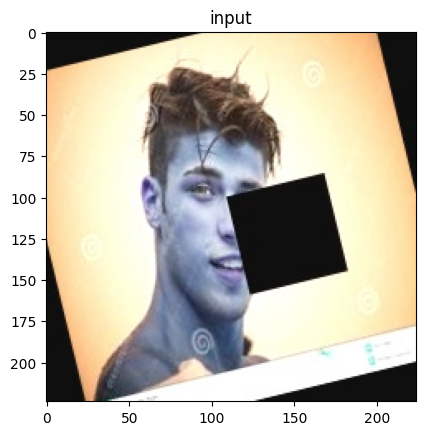

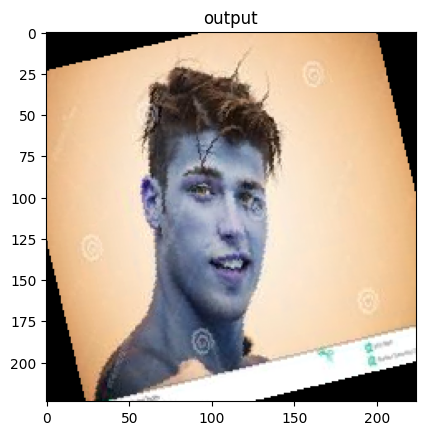

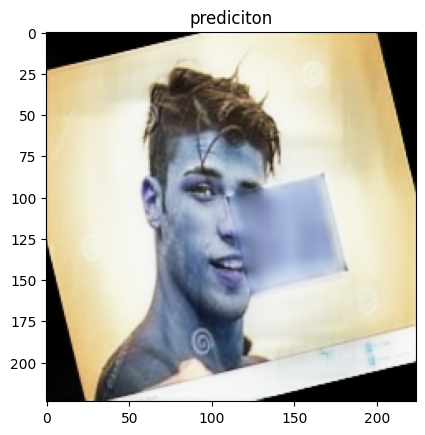

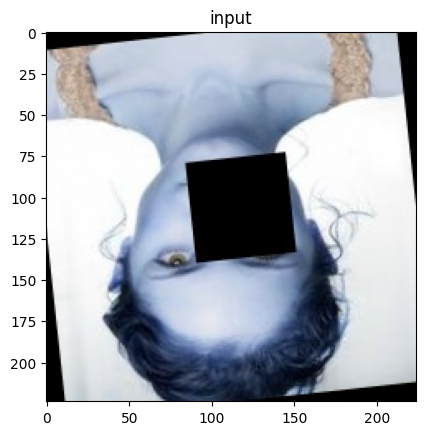

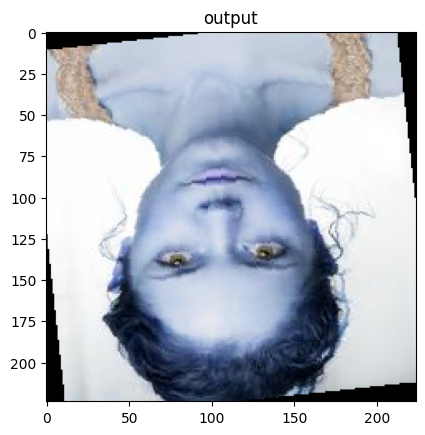

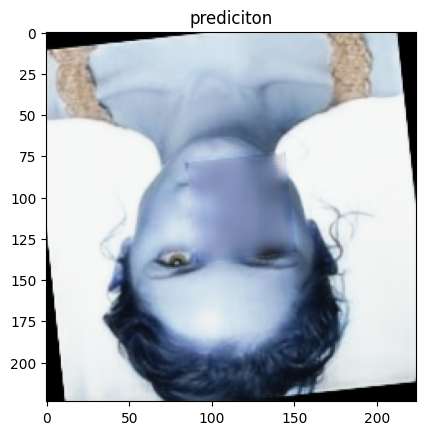

In [80]:
for i in range(5):
    plt.imshow(test_x[i])
    plt.title('input')
    plt.show()

    plt.imshow(test_y[i])
    plt.title('output')
    plt.show()

    plt.imshow(pred[i])
    plt.title('prediciton')
    plt.show()